DeepLarning Couse MSU 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин ```jheuristic@yandex-team.ru```
* ```https://vk.com/ars.ashuha```

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-14 20:49:03--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/T875wO3FYL5vY66f01G8FuG1KFGzfdQH39VPpeDIhrM2kaGYWwMq7ttXtIlbnOdz/file?dl=1 [following]
--2017-05-14 20:49:03--  https://dl.dropboxusercontent.com/content_link/T875wO3FYL5vY66f01G8FuG1KFGzfdQH39VPpeDIhrM2kaGYWwMq7ttXtIlbnOdz/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: 'data.tar.gz'

data.tar.gz         100%[===================>] 482.77M  34.2MB/s    in 15s     

2017-05-14 20:49:18 (32.5 MB/s) - 'data.tar.gz' saved

### Data preprocessing

In [156]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.4 s, sys: 288 ms, total: 2.68 s
Wall time: 2.68 s


In [157]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [158]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [159]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
from collections import Counter
word_counts = dict()
for sentences in captions:
    for sentence in sentences:
        for word in sentence:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [160]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [161]:
#try it out on several descriptions of a random image
as_matrix(captions[1340])

array([[ 8481,  8717,   346,  9042,  3974,  3980,  8717,  4370,   326,
         1918,  4859,   128,  8134,    -1],
       [ 8481,  8717,  7894,   326,  2852,  3081,   128, 10058,  5155,
         9819,  3980,  3323,  4364,  8134],
       [ 8481,  2852,  7829,  9795,  1407,   326,  3703,  4859,  3057,
         8134,    -1,    -1,    -1,    -1],
       [ 8481,  8717,  3302,  3980,  3323,  4364,  4859,  8717,  5480,
         7894,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  7894,   326,  8797,  2815,  7813,  3980,  3323,
         4364,  8134,    -1,    -1,    -1]], dtype=int32)

### Mah Neural Network

In [185]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 256 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [186]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [187]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [188]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [189]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, 0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [190]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=10)

In [191]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer, UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ", broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [192]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = (loss*output_mask).sum() / output_mask.sum()

In [193]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights)

In [194]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [195]:
captions = np.array(captions)

In [196]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [197]:
generate_batch(img_codes,captions, 3)

(array([[-6.22343302, -4.75829363,  0.07107691, ..., -6.09708452,
         -1.68672526,  1.3714757 ],
        [-1.82642663, -2.78391099,  2.03931785, ..., -5.58762407,
         -0.13364124,  0.51106149],
        [-2.18312311, -3.02944636, -2.21945214, ..., -1.47988343,
         -0.21301121,  2.1230793 ]], dtype=float32),
 array([[ 8481,  8717,  5324,  5608,   781,  3323,  8025,  4859,  8717,
          2925,  8134,    -1,    -1,    -1,    -1,    -1,    -1],
        [ 8481,  8717,  8946,  4859,  2665,  1108,  6766,    22,  8570,
          2667,  8717,  2025,   781,  8717, 10336,  4994,  8134],
        [ 8481,  8717,  4888,  3069,  5302,  4859,  5448,   766,  3980,
          5448,  1195,  8134,    -1,    -1,    -1,    -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [198]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [199]:
from tqdm import tqdm_notebook

for epoch in xrange(n_epochs):
    train_loss=0
    for _ in tqdm_notebook(xrange(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in xrange(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")



Epoch: 0, train loss: 6.72414170265, val loss: 5.50378189087




Epoch: 1, train loss: 5.34892196655, val loss: 5.19147815704




Epoch: 2, train loss: 5.04680223465, val loss: 4.89705429077




Epoch: 3, train loss: 4.79154016495, val loss: 4.68556165695




Epoch: 4, train loss: 4.58190452576, val loss: 4.48930244446




Epoch: 5, train loss: 4.38842447281, val loss: 4.37666826248




Epoch: 6, train loss: 4.29730710983, val loss: 4.15262432098




Epoch: 7, train loss: 4.23898528099, val loss: 4.14215459824




Epoch: 8, train loss: 4.10327094555, val loss: 3.9614575386




Epoch: 9, train loss: 4.01130618572, val loss: 3.95133628845




Epoch: 10, train loss: 3.96375089169, val loss: 3.84501190186




Epoch: 11, train loss: 3.87528913021, val loss: 3.78759307861




Epoch: 12, train loss: 3.79028846741, val loss: 3.76680884361




Epoch: 13, train loss: 3.7682596302, val loss: 3.71313810349




Epoch: 14, train loss: 3.69818313599, val loss: 3.70958948135




Epoch: 15, train loss: 3.67839105606, val loss: 3.66210341454




Epoch: 16, train loss: 3.6106714201, val loss: 3.68946709633




Epoch: 17, train loss: 3.5720246172, val loss: 3.60285859108




Epoch: 18, train loss: 3.5239603138, val loss: 3.48360595703




Epoch: 19, train loss: 3.52968827724, val loss: 3.62636647224




Epoch: 20, train loss: 3.48425906658, val loss: 3.56352057457




Epoch: 21, train loss: 3.41497507095, val loss: 3.36156353951




Epoch: 22, train loss: 3.45594545841, val loss: 3.47828354836




Epoch: 23, train loss: 3.42361528397, val loss: 3.51871881485




Epoch: 24, train loss: 3.37693265915, val loss: 3.41147603989




Epoch: 25, train loss: 3.32782915115, val loss: 3.28311266899




Epoch: 26, train loss: 3.35289172649, val loss: 3.30541448593




Epoch: 27, train loss: 3.34960111141, val loss: 3.42284197807




Epoch: 28, train loss: 3.27642571449, val loss: 3.17322406769




Epoch: 29, train loss: 3.28351763725, val loss: 3.2896463871




Epoch: 30, train loss: 3.27039861202, val loss: 3.22297120094




Epoch: 31, train loss: 3.24243080139, val loss: 3.17165904045




Epoch: 32, train loss: 3.21666922092, val loss: 3.29785809517




Epoch: 33, train loss: 3.203286376, val loss: 3.16628494263




Epoch: 34, train loss: 3.18479631901, val loss: 3.40913405418




Epoch: 35, train loss: 3.19617072582, val loss: 3.01708464622




Epoch: 36, train loss: 3.16788347244, val loss: 3.10201058388




Epoch: 37, train loss: 3.19143675804, val loss: 3.26927914619




Epoch: 38, train loss: 3.17803972244, val loss: 3.00799150467




Epoch: 39, train loss: 3.14828734398, val loss: 3.14088234901




Epoch: 40, train loss: 3.11927678108, val loss: 3.19612522125




Epoch: 41, train loss: 3.12859713554, val loss: 3.13099079132




Epoch: 42, train loss: 3.12817691803, val loss: 3.04746651649




Epoch: 43, train loss: 3.10273064137, val loss: 3.09227604866




Epoch: 44, train loss: 3.08532756329, val loss: 3.1227742672




Epoch: 45, train loss: 3.05589860916, val loss: 3.01505274773




Epoch: 46, train loss: 3.07232568264, val loss: 3.15918850899




Epoch: 47, train loss: 3.06309079647, val loss: 2.90128817558




Epoch: 48, train loss: 3.08762765884, val loss: 3.01603341103




Epoch: 49, train loss: 3.03983076572, val loss: 2.97255959511




Epoch: 50, train loss: 3.03139801502, val loss: 2.879814291




Epoch: 51, train loss: 3.04683426857, val loss: 3.01290450096




Epoch: 52, train loss: 3.02813982964, val loss: 2.92858142853




Epoch: 53, train loss: 3.02498634338, val loss: 3.0240483284




Epoch: 54, train loss: 2.99467627525, val loss: 2.94989056587




Epoch: 55, train loss: 2.98623494148, val loss: 2.89441184998




Epoch: 56, train loss: 2.98298388481, val loss: 2.98752245903




Epoch: 57, train loss: 2.97465517998, val loss: 2.92248597145




Epoch: 58, train loss: 2.97803449631, val loss: 2.95461921692




Epoch: 59, train loss: 2.94780736923, val loss: 2.85371570587




Epoch: 60, train loss: 3.03716290474, val loss: 3.0978808403




Epoch: 61, train loss: 2.97850531578, val loss: 2.98060936928




Epoch: 62, train loss: 2.99041242599, val loss: 2.88622174263




Epoch: 63, train loss: 2.95861555576, val loss: 3.08718876839




Epoch: 64, train loss: 2.97666549206, val loss: 2.94003248215




Epoch: 65, train loss: 2.94922105312, val loss: 2.89670381546




Epoch: 66, train loss: 2.95895837307, val loss: 2.85874009132




Epoch: 67, train loss: 2.91962618828, val loss: 3.02105941772




Epoch: 68, train loss: 2.92687373161, val loss: 2.98208241463




Epoch: 69, train loss: 2.92028441906, val loss: 2.85650057793




Epoch: 70, train loss: 2.91631945133, val loss: 2.86072459221




Epoch: 71, train loss: 2.89003370762, val loss: 2.9745757103




Epoch: 72, train loss: 2.95846050739, val loss: 2.91533489227




Epoch: 73, train loss: 2.88593604088, val loss: 2.99961385727




Epoch: 74, train loss: 2.91678090096, val loss: 2.86611685753




Epoch: 75, train loss: 2.92110728741, val loss: 2.98326621056




Epoch: 76, train loss: 2.88695402622, val loss: 2.909856987




Epoch: 77, train loss: 2.87795436859, val loss: 2.95597310066




Epoch: 78, train loss: 2.86516341686, val loss: 2.83501977921




Epoch: 79, train loss: 2.865762887, val loss: 2.89155282974




Epoch: 80, train loss: 2.87985218048, val loss: 2.86041922569




Epoch: 81, train loss: 2.88359866142, val loss: 2.87650728226




Epoch: 82, train loss: 2.86318987846, val loss: 2.99399528503




Epoch: 83, train loss: 2.84961440563, val loss: 2.73427863121




Epoch: 84, train loss: 2.86168158054, val loss: 2.87049546242




Epoch: 85, train loss: 2.84332419872, val loss: 2.76739449501




Epoch: 86, train loss: 2.84415644169, val loss: 2.83773655891




Epoch: 87, train loss: 2.86220352173, val loss: 2.89978117943




Epoch: 88, train loss: 2.83639132977, val loss: 2.86132335663




Epoch: 89, train loss: 2.83486368179, val loss: 2.92555093765




Epoch: 90, train loss: 2.85307326317, val loss: 2.75339798927




Epoch: 91, train loss: 2.80346614361, val loss: 2.80884552002




Epoch: 92, train loss: 2.86241102219, val loss: 2.74658184052




Epoch: 93, train loss: 2.83228779793, val loss: 2.81254920959




Epoch: 94, train loss: 2.86910984516, val loss: 2.85608849525




Epoch: 95, train loss: 2.79296967506, val loss: 2.82189073563




Epoch: 96, train loss: 2.81155385494, val loss: 2.78633756638




Epoch: 97, train loss: 2.82859515667, val loss: 2.70582690239




Epoch: 98, train loss: 2.81186176777, val loss: 2.88916158676




Epoch: 99, train loss: 2.83838240623, val loss: 2.81664075851
Finish :)


### apply trained model

In [200]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [201]:
!wget https://i.ytimg.com/vi/aS_UMSnxvso/maxresdefault.jpg -O data/woman_banana.jpg

--2017-05-14 21:59:24--  https://i.ytimg.com/vi/aS_UMSnxvso/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 172.217.3.174, 2607:f8b0:400a:801::200e
Connecting to i.ytimg.com (i.ytimg.com)|172.217.3.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52541 (51K) [image/jpeg]
Saving to: 'data/woman_banana.jpg'

data/woman_banana.j 100%[===================>]  51.31K  --.-KB/s    in 0.01s   

2017-05-14 21:59:24 (4.28 MB/s) - 'data/woman_banana.jpg' saved [52541/52541]



In [202]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/woman_banana.jpg')
img = preprocess(img)

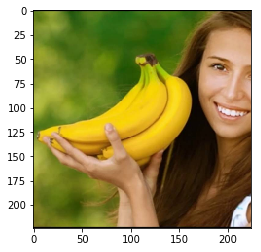

In [203]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [204]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [206]:
import os

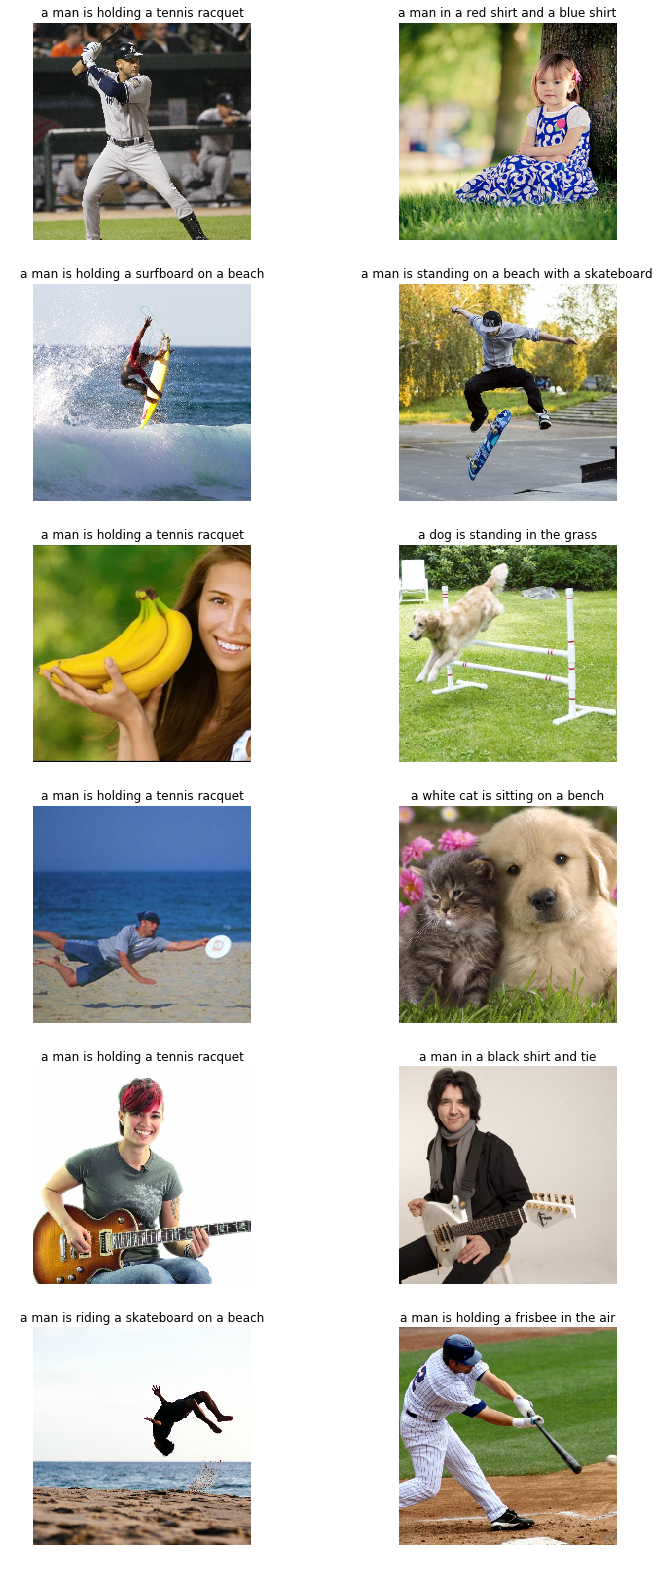

In [208]:
folder = "data/images/"
plt.figure(figsize=(12,28))
for i, file_name in enumerate(os.listdir(folder)):
    img = plt.imread(folder + file_name)
    img = preprocess(img)
    txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
    plt.subplot(6,2,i+1)
    plt.axis('off')
    plt.title(txt)
    plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))